# Forecasting Google Trend for "sunscreen" for the next year

## About the dataset
- Data obtained using Google Trends https://trends.google.com/trends/explore?date=all&geo=US&q=sunscreen&hl=en
- Access CSV here:  https://drive.google.com/file/d/1DS9_ENBsMZB7Mjd-WljuT7H2YSZ2PtF0/view?usp=sharing
- Dataset as of October 2023 also in repo as `sunscreen_popularity.txt`.

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import statsmodels.tsa.api as tsa

#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

## Custom Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax


In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts, **kwargs)
    
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {
        "Test Statistic": test_stat,
        "# of Lags Used": nlags,
        "# of Observations": nobs,
        "p-value": round(pval, 6),
        "alpha": alpha,
        "sig/stationary?": pval < alpha,
    }
    
    return pd.DataFrame(adfuller_results, index=[label])

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

## Load and Transform Data

- Load in the data, using `skiprows=[0]`
- Rename the column containing the data to "popularity"
- Convert the data column to a datetime column, then set as index
- Set time series as variable called `ts`
- Set frequency on time series index as `MS`
- Plot time series and check for nulls

In [6]:
# sunscreen
df_sun = pd.read_csv('sunscreen_popularity.txt', skiprows= [0])
df_sun.head()

,Month,sunscreen: (United States)
0,2004-01,6
1,2004-02,7
2,2004-03,9
3,2004-04,13
4,2004-05,17


In [7]:
df_sun.rename(
    columns = {'Month': 'date', 'sunscreen: (United States)': 'popularity'},
    inplace = True
)
df_sun.head()

,date,popularity
0,2004-01,6
1,2004-02,7
2,2004-03,9
3,2004-04,13
4,2004-05,17


In [8]:
# Make data a DateTime Object
df_sun['date'] = pd.to_datetime(df_sun['date'])
df_sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        238 non-null    datetime64[ns]
 1   popularity  238 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB


In [9]:
# Change datatype of popularity to numeric
df_sun['popularity'] = df_sun['popularity'].astype(float)
df_sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        238 non-null    datetime64[ns]
 1   popularity  238 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [10]:
# Set index as date
df_sun = df_sun.set_index('date')
df_sun

,popularity
date,
2004-01-01,6.0
2004-02-01,7.0
2004-03-01,9.0
2004-04-01,13.0
2004-05-01,17.0
...,...
2023-06-01,98.0
2023-07-01,100.0
2023-08-01,56.0


In [11]:
# Define the time series as ts
ts = df_sun['popularity']

In [12]:
# Set the frequency to the start of the month (does not require resampling)
ts = ts.asfreq('MS')
ts

date
2004-01-01      6.0
2004-02-01      7.0
2004-03-01      9.0
2004-04-01     13.0
2004-05-01     17.0
              ...  
2023-06-01     98.0
2023-07-01    100.0
2023-08-01     56.0
2023-09-01     37.0
2023-10-01     31.0
Freq: MS, Name: popularity, Length: 238, dtype: float64

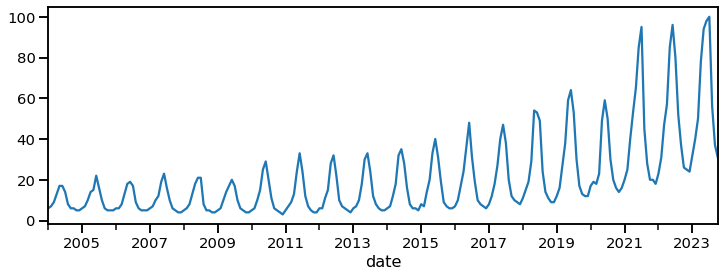

In [13]:
# Visualize the ts
ts.plot();

In [14]:
# Check for nulls
ts.isna().sum()

0

## Determine Seasonality

- Use `tsa.seasonal_decompose()` to visualize trend and seasonal elements
- Calculate the seasonal delta and account for how much variation it describes
- Plot the seasonal component
- Identify the order of seasonality

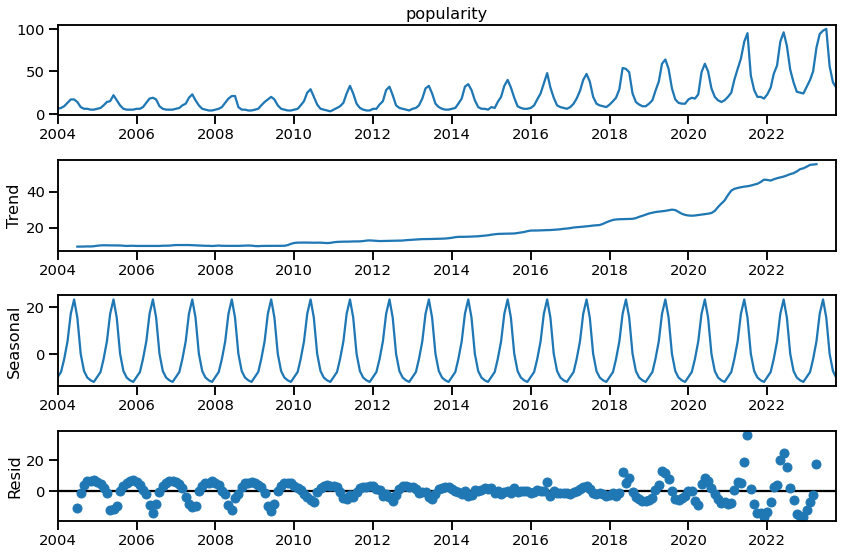

In [15]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,8)
fig.tight_layout()

In [16]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is  35.20 which is ~36.29% of the variation in time series.


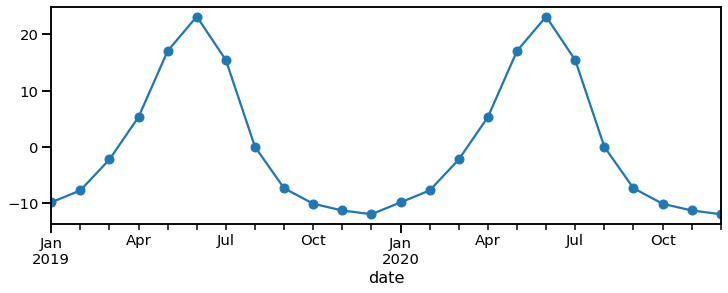

In [17]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2019': '2020'].plot(marker = 'o')

In [18]:
# From domain knowledge & counting the observations, we identify the order is 12

## Determine Stationarity/Differencing

- Use the augmented Dickey-Fuller to test for stationarity
- If necessary, find the order of differencing using `ndiffs`
- Identify the order of seasonal differencing using `nsdiffs`
- Save a differenced version of the data and plot

In [19]:
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.348296,15,222,0.998984,0.05,False


In [20]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 1


In [21]:
# Determine D
D = nsdiffs(ts, m =12)
print(f'D = {D}')

D = 1


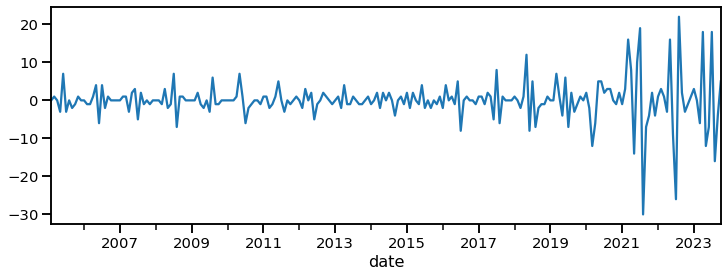

In [22]:
# apply both differencings
ts_diff = ts.diff().diff(12).dropna()
ts_diff.plot();

## Determine Initial Model Orders

- Plot the ACF and PACF of the differenced data
- Identify possible model orders

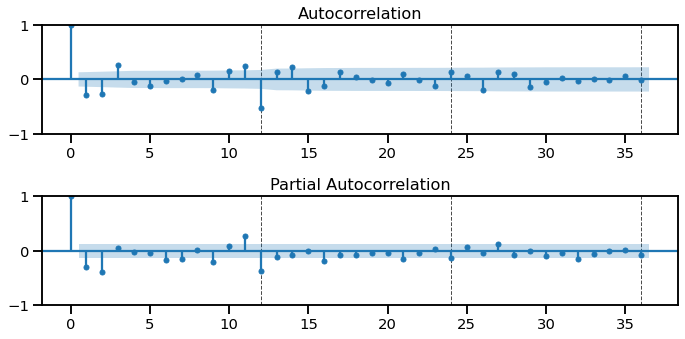

In [23]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(
    ts_diff,
    annotate_seas=True,
    m = 12,
    nlags = 36,
    pacf_kws={'method': 'ywm'}
);

In [24]:
# nonseasonal- PACF drops off after 2
# seasonal - looks like s ACF drops off after 1

## Train Test Split

- Split the data into training and testing subsets. The test set should be one year of data
- Plot the train and test sets

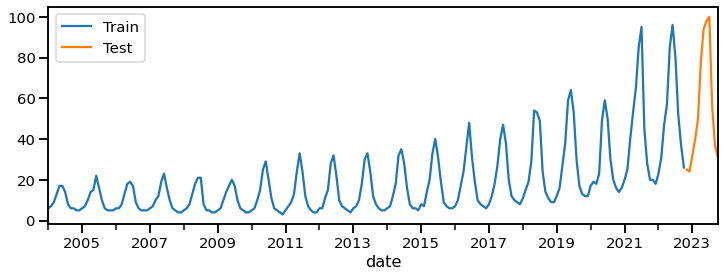

In [25]:
# tts--goal is to predict next year so 12 months
nlags = 12
train, test = train_test_split(ts, test_size=nlags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

## Modeling

- Start with an initial model using manually chosen non-seasonal and seasonal orders
- Fit a seasonal ARIMA
- Generate a forecast dataframe
- Use `plot_forecast` and `regression_metrics_ts` to evaluate the model
- Examine `model.summary()`
- Examine `model.plot_diagnostics()`

In [26]:
# Initial model

# Orders for non seasonal components
p = 2  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

model_1= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.928
- MSE = 54.420
- RMSE = 7.377
- R^2 = 0.931
- MAPE = 8.02%


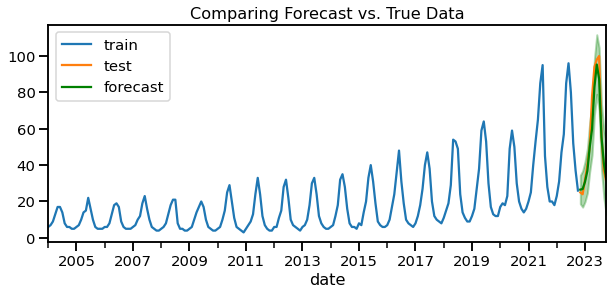

In [27]:
# Obtain summary of forecast as dataframe
forecast_df = model_1.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

In [28]:
# Obtain summary
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         popularity   No. Observations:                  226
Model:             ARIMA(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -598.470
Date:                            Thu, 26 Oct 2023   AIC                           1204.941
Time:                                    18:07:42   BIC                           1218.386
Sample:                                01-01-2004   HQIC                          1210.374
                                     - 10-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2106      0.027     -7.819      0.000      -0.263      -0.158
ar.L2         -0.2362      0.029     -8.047      0.000      -0.294      -0.179
ma.S.L12      -0.4756      0.041    -11.519      0.000      -0.557      -0.395
sigma2        15.9018      0.760     20.915      0.000      14.412      17.392
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               589.70
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              10.40   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

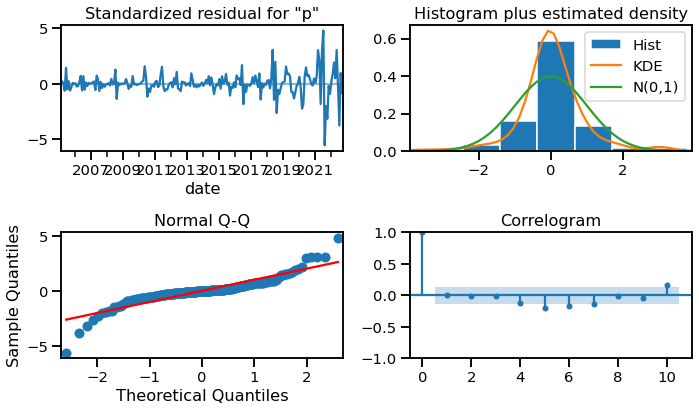

In [29]:
# Obtain diagnostic plots
fig = model_1.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## Fit alternative model using `auto_arima`

- Use `pm.auto_arima` to fit a model using AIC as a selection metric
    - Remember to set `seasonal=True` and `m=12`
    - Use `trace=True` to display metrics
- Check the best model order and seasonal order
- Examine the `model.summary()` output
- Examine `plot_diagnostics()`

In [30]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1188.767, Time=0.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1284.474, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1214.149, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1210.841, Time=0.25 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1208.435, Time=0.96 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1192.706, Time=0.80 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=1186.078, Time=2.44 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=1184.079, Time=1.81 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=1183.435, Time=1.21 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=1191.709, Time=0.54 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=1185.431, Time=1.45 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=1187.024, Time=0.99 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC=1191.167, Time=0.49 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1181.901, Time=0.68 sec
 ARIMA(1,1,1)(1,1,0

In [31]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(2, 1, 0, 12)


In [32]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  226
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -583.987
Date:                             Thu, 26 Oct 2023   AIC                           1179.975
Time:                                     18:08:14   BIC                           1200.142
Sample:                                          0   HQIC                          1188.125
                                             - 226                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0246      0.013      1.845      0.065      -0.002       0.051
ar.L1          0.6303      0.043     14.529      0.000       0.545       0.715
ma.L1         -0.9758      0.030    -32.204      0.000      -1.035      -0.916
ar.S.L12      -0.6451      0.047    -13.682      0.000      -0.738      -0.553
ar.S.L24      -0.3168      0.073     -4.312      0.000      -0.461      -0.173
sigma2        13.5419      0.650     20.848      0.000      12.269      14.815
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1407.40
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              11.55   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

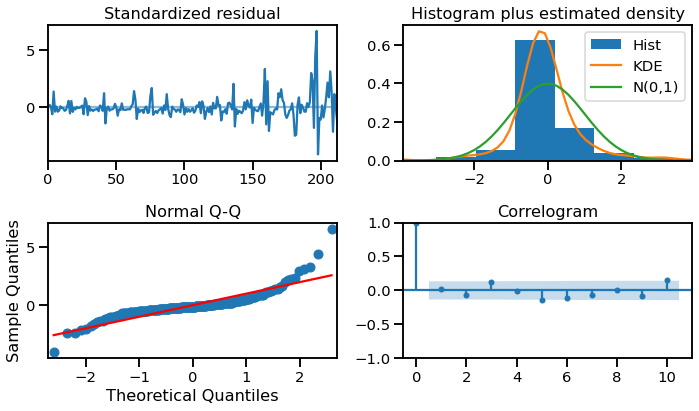

In [33]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## New ARIMA with best orders as by `auto_arima`

- Use `auto_model.order` and `auto_model.seasonal_order` to create an ARIMA model
- Evaluate the model forecast
- Which model is best?

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 5.585
- MSE = 68.744
- RMSE = 8.291
- R^2 = 0.913
- MAPE = 8.81%


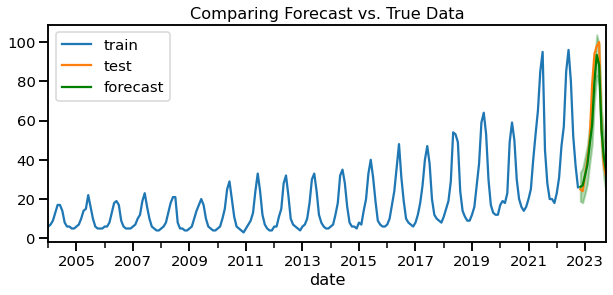

In [34]:
# Use auto_arima parameters to fit an ARIMA
model_2 = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = model_2.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

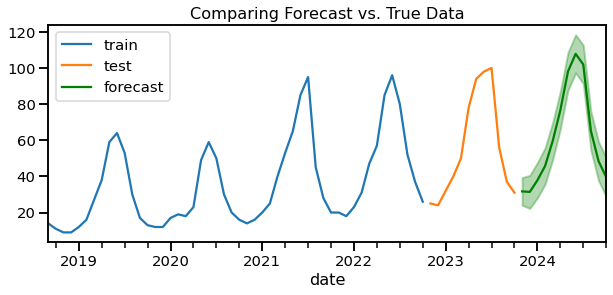

In [35]:
# Use auto_arima parameters to fit an ARIMA
final_model = tsa.ARIMA(
    ts, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df, n_train_lags = 50);

In [36]:
forecast_df['mean']

2023-11-01     31.711652
2023-12-01     31.420257
2024-01-01     37.849576
2024-02-01     45.718302
2024-03-01     59.556862
2024-04-01     76.631876
2024-05-01     98.125578
2024-06-01    107.834282
2024-07-01    101.973044
2024-08-01     65.142213
2024-09-01     48.416506
2024-10-01     39.654806
Freq: MS, Name: mean, dtype: float64

In [37]:
# Month with Maximum popularity forecasted for next year
forecast_df['mean'].idxmax()

Timestamp('2024-06-01 00:00:00', freq='MS')

In [38]:
# Month with Minmum popularity next year
forecast_df['mean'].idxmin()

Timestamp('2023-12-01 00:00:00', freq='MS')

# Final model
The metrics for the initial model and auto model are similar. We choose the auto arima model because it had a slightly lower AIC and BIC, reduced significant correlations in the residuals, and the additional coefficients were significant.